In [96]:
import os
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import hilbert

In [98]:
# Your audio folder and ground truth CSV path
audio_folder = "" # Rendered FDN Samples Folder
ground_truth_csv = "" # # Ground Truth CSV Path

TARGET_SR = 48000  # Sampling rate used in rendering

In [102]:
# Load ground truth CSV (which has no filenames)
ground_truths = pd.read_csv('')

# Get all .wav filenames in the audio folder
audio_files = sorted([f for f in os.listdir(audio_folder) if f.endswith(".wav")])

# Ensure lengths match
if len(audio_files) != len(ground_truths):
    raise ValueError(f"⚠️ File count mismatch: {len(audio_files)} audio files vs {len(ground_truths)} ground truth rows")

# Add filename column to ground truths
ground_truths["filename"] = audio_files

# Preview
ground_truths.head()

,RT60,DRR,C50,Unnamed: 3,filename
0,0.562744,-0.663958,10.819309,NaN,rendered_fdn_000_sample_000.wav
1,0.873369,-3.321323,7.682154,NaN,rendered_fdn_001_sample_001.wav
2,0.783726,0.891724,7.842788,NaN,rendered_fdn_002_sample_002.wav
3,0.754932,-7.550230,4.143937,NaN,rendered_fdn_003_sample_003.wav
4,0.704523,1.188526,9.027688,NaN,rendered_fdn_004_sample_004.wav


In [114]:
def estimate_rt60_and_c50_improved(audio, sr):
    """
    Improved estimation of RT60 and C50 for FDN-style renderings.
    Applies smoothing, adaptive decay fit, and signal-aware onset.
    """
    if audio.ndim > 1:
        audio = audio[0]  # Use left channel

    # Preprocessing
    audio = audio / np.max(np.abs(audio))  # Normalize
    energy = np.abs(hilbert(audio))**2

    # Optional: smooth energy to reduce sharp spikes
    energy_smooth = np.convolve(energy, np.ones(256) / 256, mode='same')

    # Compute Energy Decay Curve (EDC)
    edc = np.cumsum(energy_smooth[::-1])[::-1]
    edc_db = 10 * np.log10(edc / np.max(edc) + 1e-10)

    # Limit EDC to a realistic max tail (e.g., 5 sec)
    max_tail_samples = min(len(edc_db), int(5 * sr))
    edc_db = edc_db[:max_tail_samples]

    # RT60: linear regression from -5 to -35 dB if possible
    try:
        start = np.argmax(edc_db <= -5)
        end = np.argmax(edc_db <= -35)
        if end > start:
            x = np.arange(end - start) / sr
            y = edc_db[start:end]
            slope, _ = np.polyfit(x, y, 1)
            rt60_est = -60 / slope
        else:
            rt60_est = np.nan
    except Exception:
        rt60_est = np.nan

    # C50: shift to actual reverb onset before measuring early/late energy
    try:
        onset_sample = np.argmax(energy_smooth > 0.001 * np.max(energy_smooth))
        early_limit = onset_sample + int(0.05 * sr)

        early_energy = np.sum(energy_smooth[onset_sample:early_limit])
        late_energy = np.sum(energy_smooth[early_limit:])
        c50_est = 10 * np.log10(early_energy / (late_energy + 1e-10))
    except Exception:
        c50_est = np.nan

    return rt60_est, c50_est

In [116]:
results = []

for fname in audio_files:
    full_path = os.path.join(audio_folder, fname)

    try:
        audio, sr = librosa.load(full_path, sr=TARGET_SR, mono=False)
        rt60_est, c50_est = estimate_rt60_and_c50(audio, sr)

        results.append({
            "filename": fname,
            "estimated_rt60": rt60_est,
            "estimated_c50": c50_est
        })
    except Exception as e:
        print(f"⚠️ Error processing {fname}: {e}")
        results.append({
            "filename": fname,
            "estimated_rt60": np.nan,
            "estimated_c50": np.nan
        })

results_df = pd.DataFrame(results)
results_df.head()

,filename,estimated_rt60,estimated_c50
0,rendered_fdn_000_sample_000.wav,20.100174,-49.499983
1,rendered_fdn_001_sample_001.wav,9.666859,-39.009738
2,rendered_fdn_002_sample_002.wav,27.050783,-42.112483
3,rendered_fdn_003_sample_003.wav,23.536738,-39.144125
4,rendered_fdn_004_sample_004.wav,7.121016,-41.928270


In [118]:
# Merge ground truths with estimates using filename
merged_df = pd.merge(ground_truths, results_df, on="filename", how="inner")

# Rename ground truth columns if needed
merged_df["rt60_error"] = merged_df["estimated_rt60"] - merged_df["RT60"]
merged_df["c50_error"] = merged_df["estimated_c50"] - merged_df["C50"]

merged_df.head()

,RT60,DRR,C50,Unnamed: 3,filename,estimated_rt60,estimated_c50,rt60_error,c50_error
0,0.562744,-0.663958,10.819309,NaN,rendered_fdn_000_sample_000.wav,20.100174,-49.499983,19.537430,-60.319292
1,0.873369,-3.321323,7.682154,NaN,rendered_fdn_001_sample_001.wav,9.666859,-39.009738,8.793490,-46.691892
2,0.783726,0.891724,7.842788,NaN,rendered_fdn_002_sample_002.wav,27.050783,-42.112483,26.267057,-49.955271
3,0.754932,-7.550230,4.143937,NaN,rendered_fdn_003_sample_003.wav,23.536738,-39.144125,22.781807,-43.288062
4,0.704523,1.188526,9.027688,NaN,rendered_fdn_004_sample_004.wav,7.121016,-41.928270,6.416493,-50.955958


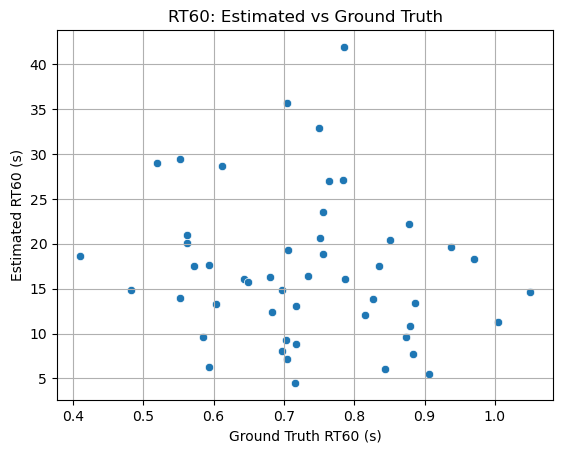

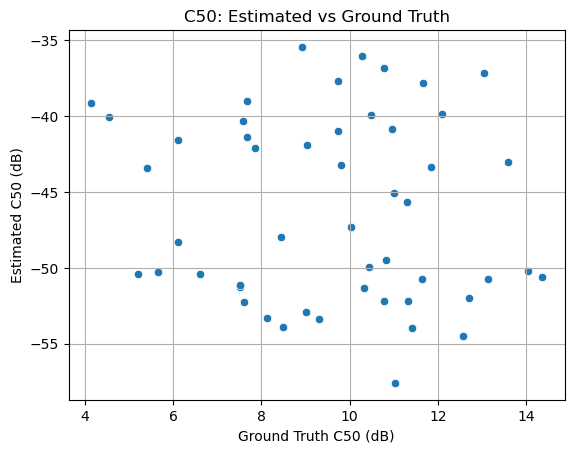

In [120]:
import seaborn as sns

# RT60 comparison
sns.scatterplot(data=merged_df, x="RT60", y="estimated_rt60")
plt.title("RT60: Estimated vs Ground Truth")
plt.xlabel("Ground Truth RT60 (s)")
plt.ylabel("Estimated RT60 (s)")
plt.grid(True)
plt.show()

# C50 comparison
sns.scatterplot(data=merged_df, x="C50", y="estimated_c50")
plt.title("C50: Estimated vs Ground Truth")
plt.xlabel("Ground Truth C50 (dB)")
plt.ylabel("Estimated C50 (dB)")
plt.grid(True)
plt.show()

In [122]:
# Export merged results (including RT60/C50 estimates and errors)
output_path = "estimated_vs_groundtruth_rt60_c50.csv"
merged_df.to_csv(output_path, index=False)
print(f"✅ Exported to: {output_path}")

✅ Exported to: estimated_vs_groundtruth_rt60_c50.csv
